<a href="https://colab.research.google.com/github/vladmark/graph-convolutional-networks-/blob/main/GCN%20and%20GAT%20in%20protein%20databases%20notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Prequisitories

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
! pip install torchviz
import numpy as np
import pandas as pd
import string
import json
import torch.nn as nn
import torch
from sklearn import preprocessing
import torch.nn.functional as F
import torchviz

     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=a1eece375a248c7ae7e35fc1fec92ec7923e5e18325606c43a7b4646b7025046
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

**Basepath to project folder in drive**

In [ ]:
basepath='/content/drive/My Drive/Proiect Deep/'

#1. Data

In [ ]:
def get_data_from_file(filename):
    f=open(filename,"r")
    data=json.load(f)
    f.close()
    return(data)

In [ ]:
!ls "$basepath"

adj_matrices_comps
gat100_2layer__intermtwiceinput
gat100_3layer__intermtwiceinput
gat100_intermtwiceinput
gat130_2layer_nobias_intermtwiceinput
gat150_2layer__intermtwiceinput
gat150_2layer_nobias_intermtwiceinput
gat150_3layer__intermtwiceinput
gat150_3layer_nobias_intermtwiceinput
gat200_2layer__intermtwiceinput
gat300_2layer_nobias_intermtwiceinput
gat50_2layer_nobias_intermtwiceinput
gat_adjacency_emb100_intermtwiceinput
gat_adj_test_losses_100_intermtwiceinput
gat_adj_test_scores_100_intermtwiceinput
gat_adj_train_scores_100_intermtwiceinput
gat_adj_val_losses_100_intermtwiceinput
gat_adj_val_scores_100_intermtwiceinput
gat_emb100_intermtwiceinput
gat_test_losses_100_2layer__intermtwiceinput
gat_test_losses_100_3layer__intermtwiceinput
gat_test_losses_100_intermtwiceinput
gat_test_losses_130_2layer_nobias_intermtwiceinput
gat_test_losses_150_2layer__intermtwiceinput
gat_test_losses_150_2layer_nobias_intermtwiceinput
gat_test_losses_150_3layer__intermtwiceinput
gat_test_losses_150

From https://github.com/williamleif/GraphSAGE

As input, at minimum the code requires that a --train_prefix option is specified which specifies the following data files:

* train_prefix-G.json -- A networkx-specified json file describing the input graph. Nodes have 'val' and 'test' attributes specifying if they are a part of the validation and test sets, respectively.
* train_prefix-id_map.json -- A json-stored dictionary mapping the graph node ids to consecutive integers.
* train_prefix-class_map.json -- A json-stored dictionary mapping the graph node ids to classes.
* train_prefix-feats.npy [optional] --- A numpy-stored array of node features; ordering given by id_map.json. Can be omitted and only identity features will be used.
* train_prefix-walks.txt [optional] --- A text file specifying random walk co-occurrences (one pair per line) (*only for unsupervised version of graphsage)



## Processing data and statistics

In [ ]:
class_map=get_data_from_file(basepath+"ppi-class_map.json")
feats=np.load(basepath+"ppi-feats.npy")
G=get_data_from_file(basepath+"ppi-G.json")
id_map=get_data_from_file(basepath+"ppi-id_map.json")

### Id map

In [ ]:
id_map_list=id_map.items()
print(id_map_list)

dict_items([('0', 0), ('1', 1), ('2', 2), ('3', 3), ('4', 4), ('5', 5), ('6', 6), ('7', 7), ('8', 8), ('9', 9), ('10', 10), ('11', 11), ('12', 12), ('13', 13), ('14', 14), ('15', 15), ('16', 16), ('17', 17), ('18', 18), ('19', 19), ('20', 20), ('21', 21), ('22', 22), ('23', 23), ('24', 24), ('25', 25), ('26', 26), ('27', 27), ('28', 28), ('29', 29), ('30', 30), ('31', 31), ('32', 32), ('33', 33), ('34', 34), ('35', 35), ('36', 36), ('37', 37), ('38', 38), ('39', 39), ('40', 40), ('41', 41), ('42', 42), ('43', 43), ('44', 44), ('45', 45), ('46', 46), ('47', 47), ('48', 48), ('49', 49), ('50', 50), ('51', 51), ('52', 52), ('53', 53), ('54', 54), ('55', 55), ('56', 56), ('57', 57), ('58', 58), ('59', 59), ('60', 60), ('61', 61), ('62', 62), ('63', 63), ('64', 64), ('65', 65), ('66', 66), ('67', 67), ('68', 68), ('69', 69), ('70', 70), ('71', 71), ('72', 72), ('73', 73), ('74', 74), ('75', 75), ('76', 76), ('77', 77), ('78', 78), ('79', 79), ('80', 80), ('81', 81), ('82', 82), ('83', 83), 

For this dataset `id_map` is not useful, node ids are already consecutive integers.

### The graph

In [ ]:
print(f'graph big structure keys: {G.keys()}')

graph big structure keys: dict_keys(['directed', 'graph', 'nodes', 'links', 'multigraph'])


In [ ]:
graph=G['graph']
links=G['links']
nodes=G['nodes']
directed=G['directed']
multigraph=G['multigraph']
print(f'graph: {graph}')
print(f'graph keys: {graph.keys()}')
print(f'is it multigraph?: {multigraph}')
print(f'is it directed graph?: {directed}')

graph: {}
graph keys: dict_keys([])
is it multigraph?: False
is it directed graph?: False


In [ ]:
print(f'nodes datatype: {type(nodes)}')
print(f'links datatype: {type(links)}')

nodes datatype: <class 'list'>
links datatype: <class 'list'>


In [ ]:
print(f'first 5 nodes look like: {nodes[:5]}')
print(f'first 5 links look like: {links[:5]}')
print(f'we have {len(nodes)} nodes')
print(f'we have {len(links)} links')

first 5 nodes look like: [{'test': False, 'id': 0, 'val': False}, {'test': False, 'id': 1, 'val': False}, {'test': False, 'id': 2, 'val': False}, {'test': False, 'id': 3, 'val': False}, {'test': False, 'id': 4, 'val': False}]
first 5 links look like: [{'source': 0, 'target': 372}, {'source': 0, 'target': 1101}, {'source': 0, 'target': 766}, {'source': 1, 'target': 640}, {'source': 1, 'target': 1}]
we have 56944 nodes
we have 818716 links


### Classes

In [ ]:
class_map_list=[(node_id, class_map[node_id]) for node_id in class_map.keys()]

In [ ]:
print(f'{len(class_map_list)} nodes have labeled classes ({"{:.0%}".format(len(class_map_list)/len(nodes))} of all nodes)')
no_classes=len(class_map_list[0][1])
print(f'we have {no_classes} classes')
class_freq=torch.mean(torch.FloatTensor(np.array([class_map_list[i][-1] for i in range(len(class_map_list))])) , dim=0)
print(f'class frequencies are: {class_freq} (for check - of len {len(class_freq)})')
print(f'average of class frequencies is: {torch.mean(class_freq)}')
print(f'std of class frequencies is: {torch.std(class_freq)}')

56944 nodes have labeled classes (100% of all nodes)
we have 121 classes
class frequencies are: tensor([0.6525, 0.2411, 0.2072, 0.2441, 0.1294, 0.1939, 0.2476, 0.3548, 0.1546,
        0.3467, 0.2175, 0.2377, 0.7080, 0.1882, 0.1852, 0.3696, 0.1037, 0.1405,
        0.2691, 0.4257, 0.1913, 0.6281, 0.2307, 0.3249, 0.1628, 0.6328, 0.6683,
        0.3346, 0.6971, 0.1775, 0.6815, 0.1441, 0.8882, 0.1629, 0.2163, 0.3273,
        0.1971, 0.2099, 0.4120, 0.2150, 0.1446, 0.2073, 0.2057, 0.2025, 0.1339,
        0.2804, 0.3878, 0.3954, 0.2416, 0.2320, 0.3552, 0.2947, 0.4343, 0.4165,
        0.2517, 0.2608, 0.1642, 0.1669, 0.1693, 0.2303, 0.4540, 0.1563, 0.1919,
        0.2150, 0.2030, 0.1243, 0.4965, 0.3297, 0.4750, 0.2833, 0.2416, 0.1628,
        0.1639, 0.2921, 0.1913, 0.1919, 0.3241, 0.1334, 0.2681, 0.2322, 0.2197,
        0.5050, 0.2787, 0.1937, 0.1618, 0.5783, 0.0922, 0.2847, 0.2784, 0.1998,
        0.1743, 0.2599, 0.3216, 0.1780, 0.1989, 0.3046, 0.1747, 0.4082, 0.4378,
        0.2657, 0.5067, 

### Features

In [ ]:
print(f'we have {feats.shape[-1]} features')
print(f'a feature sample: {feats[869]}')
print(f'features have frequency: {np.mean(feats, axis=0)}')
print(f'average of feature frequencies: {np.mean(np.mean(feats, axis=0))}')
print(f'std of feature frequencies: {np.std(np.mean(feats, axis=0))}')

we have 50 features
a feature sample: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
features have frequency: [0.00732298 0.0075864  0.01259132 0.02857193 0.00590053 0.00990447
 0.00565468 0.01283717 0.01450548 0.00986935 0.         0.0281329
 0.00186148 0.01231034 0.00567224 0.01301278 0.01046642 0.01250351
 0.02005479 0.0093952  0.00748103 0.02059919 0.01496207 0.01520792
 0.00962349 0.01403133 0.01325864 0.00528589 0.00432003 0.00744591
 0.03110073 0.02044114 0.02467336 0.02435726 0.02123139 0.15808514
 0.02514751 0.02344409 0.0224431  0.01908893 0.01638452 0.02300506
 0.02477873 0.02325091 0.02080992 0.02037089 0.02368994 0.01889576
 0.02189871 0.02165285]
average of feature frequencies: 0.018502388311323406
std of feature frequencies: 0.021335246068387024


In [ ]:
zero_feats_row_indexes=[i for i in range(feats.shape[0]) if np.mean(feats[i])==0.]

In [ ]:
zero_classes_ids=[idx for (idx, idxlabels) in class_map.items() if np.mean(np.array(idxlabels)) != 0]

In [ ]:
zero_classes_ids=[int(el) for el in zero_classes_ids]
zero_feats_non_zero_classes=[i for i in zero_feats_row_indexes if i in zero_classes_ids]

In [ ]:
print(f'{"{:.2%}".format(len(zero_feats_row_indexes)/feats.shape[0])} of all nodes have all features 0')
print(f'{"{:.2%}".format(len(zero_feats_non_zero_classes)/feats.shape[0])} of all nodes have all features 0 but output classes non-zero')

42.52% of all nodes have all features 0
40.95% of all nodes have all features 0 but output classes non-zero


In [ ]:
feats=torch.FloatTensor(feats)

## Train, val, test **ids** set construction

In [ ]:
train_ids=[nodes[i]['id'] for i in range(len(nodes)) if nodes[i]['test']==False and nodes[i]['val']==False]
val_ids=[nodes[i]['id'] for i in range(len(nodes)) if nodes[i]['val']==True]
test_ids=[nodes[i]['id'] for i in range(len(nodes)) if nodes[i]['test']==True]
assert len(train_ids)+len(val_ids)+len(test_ids) == len(nodes), "Seturile de train, validare, test nu dau tot datasetul"

In [ ]:
print(f'train is {"{:.00%}".format(len(train_ids)/len(nodes))} percent of dataset')
print(f'validation is {"{:.00%}".format(len(val_ids)/len(nodes))} percent of dataset')
print(f'test is {"{:.00%}".format(len(test_ids)/len(nodes))} percent of dataset')

train is 79% percent of dataset
validation is 11% percent of dataset
test is 10% percent of dataset


In [ ]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

44906
6514
5524


## Link dict construction (a usable dictionary for GCN)

Construct a dict which has as
* **node ids** as **keys**
* **adjacent nodes** (as a **set**) as **values**

In [ ]:
def construct_adjacency_dict(links, directed, always_self_loop=False ):
  adj={}
  for link in links:
    source=link['source']
    target=link['target']
    if source not in adj.keys() and target not in adj.keys():
      adj[source]=set([target])
      if (not directed):
        adj[target]=set([source])
    elif source not in adj.keys():
      adj[source]=set([target])
      if (not directed):
        adj[target]=adj[target] | set([source])
    elif target not in adj.keys():
      adj[source]=adj[source] | set([target])
      if (not directed):
        adj[target]=set([source])
    else:
      adj[source]=adj[source] | set([target])
      adj[target]=adj[target] | set([source])
    if always_self_loop:
      adj[source]=adj[source] | set([source])
      adj[target]=adj[target] | set([target])
  return adj

In [ ]:
adj=construct_adjacency_dict(links, directed, always_self_loop=True)
assert len(adj.keys())==len(nodes), "Avem noduri neconectate la nimic"

In [ ]:
print(adj[5])
adj_dict=adj
print(type(adj[5]))

{640, 1, 258, 1219, 100, 5, 483, 1546, 46, 464, 433, 563, 181, 1019, 1180}
<class 'set'>


## Getting connected components

In [ ]:
def connected_components(neighbors):
    seen = set()
    def component(node):
        nodes = set([node])
        while nodes:
            node = nodes.pop()
            seen.add(node)
            nodes |= neighbors[node] - seen
            yield node
    for node in neighbors:
        if node not in seen:
            yield component(node)
connected_comps=[]
for component in connected_components(adj_dict):
  connected_comps.append(set(component))
print(len(connected_comps))

295


### Component adjacency matrices

In [ ]:
# adj_matrices_comps=[]
feats_comps=[]
classes_comps=[]
node_to_index_mappings=[]
index_to_node_mappings=[]
for comp in connected_comps:
  comp=list(comp)
  node_to_index_mapping={}
  index_to_node_mapping={}
  i=0
  for node in comp:
    node_to_index_mapping[node]=i
    index_to_node_mapping[i]=node
    i=i+1
  node_to_index_mappings.append(node_to_index_mapping)
  index_to_node_mappings.append(index_to_node_mapping)
  feats_comps.append(feats[comp])
  classes_comps.append(torch.tensor([class_map[str(node)] for node in comp]) )
  # adj_matrices_comps.append(torch.tensor([ [1 if i in [reordering[neighbor] for neighbor in adj_dict[node]] else 0 for i in range(len(comp))] for node in comp]) )

In [ ]:
# import pickle
# with open(basepath+"adj_matrices_comps", "wb") as file: 
#   pickle.dump(adj_matrices_comps, file)

Load component adj matrix

In [ ]:
import pickle
with open(basepath+"adj_matrices_comps", "rb") as file: 
  loaded_adj_matrices_comps=pickle.load(file)

In [ ]:
adj_matrices_comps=loaded_adj_matrices_comps

In [ ]:
# adj_matrices_comps=[matrix.type(torch.FloatTensor) for matrix in loaded_adj_matrices_comps]

In [ ]:
# for adj_matrix in adj_matrices_comps:
#   adj_matrix[adj_matrix==0]=float('-inf')

In [ ]:
print(len(adj_matrices_comps))

295


In [ ]:
print(torch.mean(torch.Tensor([len(component) for component in connected_comps if len(component)>1])))

tensor(1453.5385)


In [ ]:
print(torch.sum(torch.tensor([len(component)==1 for component in connected_comps])))

tensor(256)


In [ ]:
print(adj_matrices_comps[0])

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]])


### Separate each component into train val test

In [ ]:
components_train_indexes = []
components_val_indexes = []
components_test_indexes = []
components_classes_train = []
components_classes_val = []
components_classes_test = []
no_train_comps=0
no_val_comps=0
no_test_comps=0
for component_id in range(len(connected_comps)):
  component_train_ids=set(connected_comps[component_id]) & set(train_ids)
  component_train_indexes=[]
  comp_classes_train=[]
  if component_train_ids:
    no_train_comps+=1
    component_train_indexes=[node_to_index_mappings[component_id][node_id] for node_id in component_train_ids]
    comp_classes_train=classes_comps[component_id][component_train_indexes]
  components_train_indexes.append(component_train_indexes)
  components_classes_train.append(comp_classes_train)

  component_val_ids=set(connected_comps[component_id]) & set(val_ids)
  component_val_indexes=[]
  comp_classes_val=[]
  if component_val_ids:
    no_val_comps+=1
    component_val_indexes=[node_to_index_mappings[component_id][node_id] for node_id in component_val_ids]
    comp_classes_val=classes_comps[component_id][component_val_indexes]
  components_val_indexes.append(component_val_indexes)
  components_classes_val.append(comp_classes_val)

  component_test_ids=set(connected_comps[component_id]) & set(test_ids)
  component_test_indexes=[]
  comp_classes_test=[]
  if component_test_ids:
    no_test_comps+=1
    component_test_indexes=[node_to_index_mappings[component_id][node_id] for node_id in component_test_ids]
    comp_classes_test=classes_comps[component_id][component_test_indexes]
  components_test_indexes.append(component_test_indexes)
  components_classes_test.append(comp_classes_test)


In [ ]:
class ComponentsSeparatedData():
  def __init__(self, components_train_indexes = [], components_val_indexes = [], components_test_indexes = [],
                components_classes_train = [], components_classes_val = [], components_classes_test = [], no_train_comps=0, no_val_comps=0, no_test_comps=0):
    self.components_train_indexes=components_train_indexes
    self.components_val_indexes=components_val_indexes
    self.components_test_indexes=components_test_indexes
    self.components_classes_train=components_classes_train
    self.components_classes_val=components_classes_val
    self.components_classes_test=components_classes_test
    self.no_train_comps=no_train_comps
    self.no_val_comps=no_val_comps
    self.no_test_comps=no_test_comps

components_separated_data=ComponentsSeparatedData(components_train_indexes, components_val_indexes, components_test_indexes,
                components_classes_train, components_classes_val, components_classes_test, no_train_comps, no_val_comps, no_test_comps)

##Construct (sparse) adjacency matrix (from previously constructed dict)

In [ ]:
def construct_sparse_adjacency_matrix(adj_dict: dict, indeces=None):
  """
  !!WARNING: about 30-40 minute runtime for ppi dataset
  will only construct the indeces and then a vector of ones of length the components of the shape of the indeces vector multiplied
  indeces will be a vector of dim 2 x number of neighbors that need to be specified. first line = node index, second line = neighbor index
  we need to cat on to the indeces along the second dimension because we keep adding columns
  """
  if indeces == None:
    print('We have to construct indeces vector. Brace yourself, it will take a while!')
    indeces=torch.LongTensor(2, 1)
    for node in adj_dict.keys():
      for neighbor in adj_dict[node]:
        indeces=torch.cat( (indeces, torch.unsqueeze(torch.LongTensor([node, neighbor]), dim=1) ), dim=1) #unsqueeze along dim 1 will make 1 column and 2 lines
    indeces=indeces[:, 1:] #eliminates first column which has arbitrary content and was created in declaration
  values=torch.ones(indeces.shape[1])
  adj_sparse_matrix=torch.sparse.ShortTensor(indeces, values, torch.Size([len(adj_dict.keys()),len(adj_dict.keys())]))
  return adj_sparse_matrix


### Working with indeces as they are

In [ ]:
indeces_loaded=torch.load(basepath+'sparse_adjacency_matrix_indeces.pt')
print(indeces_loaded[:, 600:700])

tensor([[1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194,
         1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194,
         1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194,
         1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194,
         1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1067, 1067,
         1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067,
         1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067,
         1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067, 1067,
         1067, 1067, 1067, 1067],
        [ 283,  542, 1056,  295,  298,  815, 1329,  307,  308,  309,  311, 1085,
          323,  583,  336,   86,  101,  613, 1388, 1390, 1137,  370,  371, 1397,
         1146,  890,  636, 1407, 1154, 1413,  136,  649,  911,  657,  661, 1435,
         1189, 1194,  690,  695, 1213, 1470,  191,  203,  469,  218,  989, 

In [ ]:
adj_matrix=construct_sparse_adjacency_matrix(adj_dict, indeces_loaded)

It is very interesting that only *some* nodes appear as neighbors for themselves in initial graph links. I have decided for easier implementation but also because it might be meaningful that only some nodes have links to themselves in initial graph.

Ajd matrix has therefore at **least 1** on the main diagonal and **it has 2 in the places where there is a link already in initial graph**.

In [ ]:
#construct adjacency matrix that has all values on diagonal 1
adj_matrix=adj_matrix+torch.eye(adj_matrix.shape[0]).to_sparse()

### Reprocessing indeces so that they contain all diagonal

Perhaps it doesn't make that much sense after all. Let's painfully add 1 to the diagonal where it's missing.

In [ ]:
equal=((indeces_loaded[0]-indeces_loaded[1])==0)
"""
now I want to get the elements of the first line for which the result is 1;
these will be eliminated from the set of nodes that need to be added to the diagonal
"""
already_added_nodes=[indeces_loaded[0,index] for index in range(len(indeces_loaded[0])) if equal[index]]

In [ ]:
already_added_nodes=set([int(node) for node in already_added_nodes])
print(already_added_nodes)

{1, 2, 4, 9, 10, 14, 15, 16, 18, 20, 22, 25, 29, 32, 34, 35, 36, 37, 38, 39, 46, 49, 50, 51, 54, 55, 56, 60, 61, 65, 66, 69, 72, 73, 75, 76, 79, 80, 81, 82, 85, 86, 87, 91, 93, 96, 99, 100, 101, 103, 104, 106, 110, 113, 118, 122, 123, 125, 129, 133, 135, 136, 139, 142, 143, 144, 147, 148, 150, 156, 157, 161, 164, 165, 166, 175, 176, 177, 181, 182, 183, 184, 187, 191, 192, 197, 198, 200, 201, 202, 203, 207, 208, 209, 211, 212, 215, 216, 218, 223, 224, 225, 226, 227, 228, 229, 234, 238, 239, 240, 241, 245, 246, 247, 248, 249, 251, 258, 261, 262, 263, 268, 270, 271, 275, 278, 279, 280, 281, 282, 283, 284, 285, 287, 288, 290, 291, 293, 295, 296, 297, 299, 300, 303, 305, 306, 308, 309, 310, 311, 313, 317, 322, 326, 333, 334, 335, 336, 339, 340, 343, 349, 350, 352, 353, 354, 355, 357, 362, 364, 366, 369, 370, 371, 372, 376, 380, 383, 388, 389, 392, 394, 395, 399, 402, 405, 407, 408, 409, 410, 411, 412, 413, 414, 416, 417, 418, 419, 421, 429, 430, 431, 432, 433, 435, 436, 441, 442, 443, 447, 

In [ ]:
print(len(already_added_nodes))
print(set(adj_dict.keys()) - already_added_nodes)

25084
{0, 3, 5, 6, 7, 8, 11, 12, 13, 17, 19, 21, 23, 24, 26, 27, 28, 30, 31, 33, 40, 41, 42, 43, 44, 45, 47, 48, 52, 53, 57, 58, 59, 62, 63, 64, 67, 68, 70, 71, 74, 77, 78, 83, 84, 88, 89, 90, 92, 94, 95, 97, 98, 102, 105, 107, 108, 109, 111, 112, 114, 115, 116, 117, 119, 120, 121, 124, 126, 127, 128, 130, 131, 132, 134, 137, 138, 140, 141, 145, 146, 149, 151, 152, 153, 154, 155, 158, 159, 160, 162, 163, 167, 168, 169, 170, 171, 172, 173, 174, 178, 179, 180, 185, 186, 188, 189, 190, 193, 194, 195, 196, 199, 204, 205, 206, 210, 213, 214, 217, 219, 220, 221, 222, 230, 231, 232, 233, 235, 236, 237, 242, 243, 244, 250, 252, 253, 254, 255, 256, 257, 259, 260, 264, 265, 266, 267, 269, 272, 273, 274, 276, 277, 286, 289, 292, 294, 298, 301, 302, 304, 307, 312, 314, 315, 316, 318, 319, 320, 321, 323, 324, 325, 327, 328, 329, 330, 331, 332, 337, 338, 341, 342, 344, 345, 346, 347, 348, 351, 356, 358, 359, 360, 361, 363, 365, 367, 368, 373, 374, 375, 377, 378, 379, 381, 382, 384, 385, 386, 387, 39

In [ ]:
for node in set(adj_dict.keys()) - already_added_nodes:
  indeces_loaded=torch.cat( (indeces_loaded, torch.unsqueeze(torch.LongTensor([node, node]), dim=1) ), dim=1)

In [ ]:
torch.save(indeces_loaded, basepath+'sparse_adjacency_matrix_indeces_diag_eye.pt')

### Load full diagonal indeces and construct adj matrix

In [ ]:
indeces_loaded=torch.load(basepath+'sparse_adjacency_matrix_indeces_diag_eye.pt')

In [ ]:
adj_matrix=construct_sparse_adjacency_matrix(adj_dict, indeces_loaded)

## More data processing

In [ ]:
adj_matrix=adj_matrix.type(torch.sparse.FloatTensor)

NameError: ignored

###Clean the adjacency matrix of its diagonal

Right now adj matrix has diagonal full of ones. If I want diag 0, run this.

In [ ]:
adj_matrix=adj_matrix-torch.eye(adj_matrix.shape[0]).to_sparse()

### Get the matrix to normalise adjacency matrix

Because both adjacency matrix and the normal matrix will have to be sparse (too big), I'll pass them both to the forward function and take advantage of matrix multiplication associativity

In [ ]:
sums_adj_matrix=torch.sparse.sum(adj_matrix, dim=0).to_dense()

In [ ]:
sums_adj_matrix[sums_adj_matrix==0.]=1

In [ ]:
norm_indeces=torch.cat( (torch.unsqueeze(torch.LongTensor(range(adj_matrix.shape[0])), dim=0),
                         torch.unsqueeze(torch.LongTensor(range(adj_matrix.shape[0])), dim=0) ), dim=0)
print(norm_indeces.shape)

torch.Size([2, 56944])


In [ ]:
norm_uninversed_matrix=torch.sparse.FloatTensor(norm_indeces, sums_adj_matrix, adj_matrix.shape)
norm_matrix=norm_uninversed_matrix**-1

In [ ]:
assert not torch.any(torch.isnan(torch.mm(norm_matrix, feats))), "Nan values"

# 2. A simple multi-perceptron model

### Model definition

In [ ]:
class SimpleNN(nn.Module):
  def __init__(self, in_features, out_classes):
    super().__init__()
    self.lin1=nn.Linear(in_features=in_features, out_features=1000)
    self.lin2=nn.Linear(in_features=1000, out_features=500)
    self.lin3=nn.Linear(in_features=500, out_features=125)
    self.lin4=nn.Linear(in_features=125, out_features=out_classes)
  def forward(self, x):
    out=self.lin1(x)
    out=F.relu(out)
    out=self.lin2(out)
    out=F.relu(out)
    out=self.lin3(out)
    out=F.relu(out)
    out=self.lin4(out)
    # out=torch.sigmoid(out)
    return out

### Loaders

In [ ]:
def make_batch_loader_simple_nn(ids_selector: list, id_map: dict, features: np.array, class_map: dict, batch_size: int, shuffle, device):
  """
  id_map: only used for obtaining the right line in features
  ids_selector: list of ids that are in the wanted dataset
  """
  out_feats=torch.FloatTensor(features[[id_map[str(idx)] for idx in ids_selector]])
  out_classes=torch.FloatTensor([class_map[str(idx)] for idx in ids_selector])
  out_feats=out_feats.to(device)
  out_classes=out_classes.to(device)
  from torch.utils.data import TensorDataset
  from torch.utils.data import DataLoader
  dataset = TensorDataset(out_feats, out_classes)
  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)
  return data_loader

In [ ]:
train_loader=make_batch_loader_simple_nn(ids_selector=train_ids, id_map=id_map, features=feats, class_map=class_map, batch_size=300, shuffle=True, device=device)
val_loader=make_batch_loader_simple_nn(ids_selector=val_ids, id_map=id_map, features=feats, class_map=class_map, batch_size=300, shuffle=True, device=device)
test_loader=make_batch_loader_simple_nn(ids_selector=test_ids, id_map=id_map, features=feats, class_map=class_map, batch_size=300, shuffle=True, device=device)

### Instancing

In [ ]:
no_features=feats.shape[-1]
no_classes=len(class_map['0'])
print(no_features, no_classes)
print(f'no samples: {feats.shape[0]}')

50 121
no samples: 56944


From http://hagan.okstate.edu/NNDesign.pdf#page=469

Nh=Ns/(α∗(Ni+No))

Nh = number of hidden neurons.
Ni = number of input neurons.
No = number of output neurons.
Ns = number of samples in training data set.
α = an arbitrary scaling factor usually 2-10.

Here, Ni+No=50+121=171, Ns=56944

In [ ]:
nh=56944/(2*(50+121))
print(nh)

166.50292397660817


In [ ]:
simple_nn=SimpleNN(no_features, no_classes)

In [ ]:
optim=torch.optim.Adam(simple_nn.parameters(), lr=10e-5)

### Training

In [ ]:
def train_epoch_simple_nn(model: SimpleNN, optim, train_loader: torch.utils.data.DataLoader, device, epoch, print_every=20):
  model=model.to(device)
  total_epoch_loss=0.
  loss_func=torch.nn.MultiLabelSoftMarginLoss()
  num_batches=0
  for batch_idx, (batch, batch_labels) in enumerate(train_loader):
    optim.zero_grad()
    out=model(batch)
    loss=loss_func(out, batch_labels)
    loss.backward()
    with torch.no_grad():
      optim.step()
      total_epoch_loss+=loss.item()
      num_batches+=1
      if (batch_idx%print_every == 0):
        pass
        # print(f'batch {batch_idx} has train loss {loss.item()} on epoch {epoch} \n\n')
  return total_epoch_loss/num_batches

In [ ]:
train_feats=torch.FloatTensor(feats[[id_map[str(idx)] for idx in train_ids]])
train_classes=torch.FloatTensor([class_map[str(idx)] for idx in train_ids])
val_feats=torch.FloatTensor(feats[[id_map[str(idx)] for idx in val_ids]])
val_classes=torch.FloatTensor([class_map[str(idx)] for idx in val_ids])
test_feats=torch.FloatTensor(feats[[id_map[str(idx)] for idx in test_ids]])
test_classes=torch.FloatTensor([class_map[str(idx)] for idx in test_ids])

In [ ]:
no_epochs=1000
save_every=100

In [ ]:
train_every_epoch_loss=[]
val_every_epoch_loss=[]
test_every_epoch_loss=[]

In [ ]:
save_identifier='_1000_500_125'

In [ ]:
for e in range(no_epochs):
  epoch_train_loss=train_epoch_simple_nn(simple_nn, optim, train_loader, device, e, print_every=200)
  with torch.no_grad():
    print(f'epoch {e}, train loss: {epoch_train_loss}')
    train_loss.append(epoch_train_loss)
    # lossfun=torch.nn.BCEWithLogitsLoss()
    lossfun=torch.nn.MultiLabelSoftMarginLoss()
    epoch_loss=lossfun(simple_nn(val_feats), val_classes)
    val_loss.append(epoch_loss.item())
    epoch_loss=lossfun(simple_nn(test_feats), test_classes)
    test_loss.append(epoch_loss.item())
    if (e%save_every==0):
      torch.save(simple_nn.state_dict(), basepath+'simple_nn'+save_identifier)
      print(f'epoch loss: {epoch_train_loss}')
      import pickle
      with open(basepath+'simple_nn_train_losses'+save_identifier+'.data', 'wb') as filehandle:
        pickle.dump(train_loss, filehandle)
      with open(basepath+'simple_nn_val_losses'+save_identifier+'.data', 'wb') as filehandle:
        pickle.dump(val_loss, filehandle)
      with open(basepath+'simple_nn_test_losses'+save_identifier+'.data', 'wb') as filehandle:
        pickle.dump(test_loss, filehandle)

### Loss plot n debugging

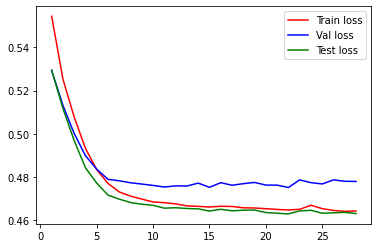

In [ ]:

import matplotlib.pyplot as plt 
plt.plot(range(1, len(train_every_epoch_loss)+1), train_every_epoch_loss, label='Train loss', color='red')
plt.plot(range(1, len(val_every_epoch_loss)+1), val_every_epoch_loss, label='Val loss', color='blue')
plt.plot(range(1, len(test_every_epoch_loss)+1), test_every_epoch_loss, label='Test loss', color='green')
plt.legend()
plt.show()

In [ ]:
print(train_every_epoch_loss[-100:])

[0.6908112541834514, 0.6870773402849834, 0.6832811224460602, 0.6792280324300131, 0.6746328024069468, 0.6691451148192088, 0.6620791947841644, 0.6523425277074179, 0.6382696628570557, 0.6180580043792725, 0.5930332748095194, 0.571335103114446, 0.5597412673632304, 0.5554999077320099, 0.5539634227752686, 0.5532084707419077, 0.5529081984361013, 0.552672442595164, 0.5525591425100962, 0.5524059307575225, 0.5523314309120179, 0.5522311063607533, 0.5521930603186289, 0.5521286722024282, 0.5520405832926433, 0.5519862552483876, 0.551916732788086, 0.5518395483493805, 0.5517500801881154, 0.5517264195283254, 0.5517147139708201, 0.5516204388936361, 0.5515858527024587, 0.5515402404467264, 0.5515417381127675, 0.551450649102529, 0.5514092858632406, 0.5513801995913188, 0.5513699634869893, 0.5513215867678324, 0.551276623805364, 0.5512818614641826, 0.551192676226298, 0.5512111290295919, 0.5511575396855672, 0.5511373635133108, 0.5511167399088541, 0.5510965160528819, 0.5510441994667054, 0.5510013790925344, 0.550

In [ ]:
with torch.no_grad():
  out_train=simple_nn(train_feats)
  print(out_train)
  loss_train=torch.mean(torch.abs(torch.round(torch.sigmoid(out_train))-train_classes))
  print(loss_train)
  out_val=simple_nn(val_feats)
  loss_val=torch.mean(torch.abs(torch.round(torch.sigmoid(out_val))-val_classes))
  print(loss_val)
  out_test=simple_nn(test_feats)
  loss_test=torch.mean(torch.abs(torch.round(torch.sigmoid(out_test))-test_classes))
  print(loss_test)

tensor([[ 0.4197, -1.1308, -1.2450,  ...,  1.5076,  0.1826, -1.3806],
        [ 0.4197, -1.1308, -1.2450,  ...,  1.5076,  0.1826, -1.3806],
        [ 0.4197, -1.1308, -1.2450,  ...,  1.5076,  0.1826, -1.3806],
        ...,
        [ 0.9724, -0.9018, -1.9089,  ...,  1.8554,  0.1453, -1.8421],
        [ 0.4197, -1.1308, -1.2450,  ...,  1.5076,  0.1826, -1.3806],
        [ 0.7044, -1.3947, -1.5047,  ...,  1.3804,  0.1407, -0.7095]])
tensor(0.2208)
tensor(0.2182)
tensor(0.2176)


###**On return**

In [ ]:
simple_nn.load_state_dict(torch.load(basepath+'simple_nn_2000_400'))

<All keys matched successfully>

In [ ]:
import pickle
with open(basepath+'simple_nn_train_losses2.data', 'rb') as filehandle:
  train_every_epoch_loss=pickle.load(filehandle)
with open(basepath+'simple_nn_val_losses2.data', 'rb') as filehandle:
  val_every_epoch_loss=pickle.load(filehandle)
with open(basepath+'simple_nn_test_losses2.data', 'rb') as filehandle:
  test_every_epoch_loss=pickle.load(filehandle)

#3. Simple variant of GCN (mean aggregator) with no adjacency matrix


In [ ]:
class GCN(nn.Module):
  def __init__(self, neighbors_depth, in_features_size, embedding_size, no_classes, aggregation_func=lambda x: torch.mean(x, dim=0)):
    super().__init__()
    self.depth=neighbors_depth-1
    self.agg=aggregation_func
    linears=[]
    self.emb_size=embedding_size
    for i in range(neighbors_depth):
      if i==0:
        linears.append(nn.Linear(in_features_size, embedding_size, bias=False))
      else:
        linears.append(nn.Linear(embedding_size, embedding_size, bias=False))
    self.linears=nn.ModuleList(linears)
    self.classifier=nn.Linear(embedding_size, no_classes)
  def forward(self, x, level):
    out=self.linears[level](self.agg(x))
    if level==self.depth:
      return out
    else:
      return F.relu(out)
  def classify(self, embedded):
    # out=F.relu(embedded)
    out=self.classifier(embedded)
    return out

## Useless now

In [ ]:
def get_neighbors(adj_dict, starting_node_id, depth, level=0):
  ids=[]
  neighbors=list(adj_dict[starting_node_id])
  if starting_node_id not in neighbors:
    neighbors.append(starting_node_id)
  print(f'node {starting_node_id} with neighbors {neighbors}')
  if (level<depth-1):
    for neighbor in neighbors:
      ids.append(get_neighbors(adj_dict, neighbor , depth, level=level+1))
  elif (level<depth):
    ids=neighbors
  return ids
a=get_neighbors(adj, 11, 3)
print(len(a))
print(a)

In [ ]:
def feed(model: GCN, adj_dict: dict, id_map: dict, starting_node_id: int, feats: torch.Tensor, depth: int, level=0):
  """
  CORE FUNCTION:
  takes a starting node and the model and produces the embedding, by recursively traversing the node's subgraph up to given depth
  for each neighbor of the node it produces the aggregation associated to that neighbor by calling recursively
  if last level is reached then produces aggregation of base features of neighbors
  """
  neighbors=list(adj_dict[starting_node_id])
  if starting_node_id not in neighbors:
    neighbors.append(starting_node_id)
  #we got the neighbors
  if (level<depth):
    feeded, grad=feed(model, adj_dict, id_map, neighbors[0], feats, depth, level=level+1)
    print(f'feeded has grad {feeded.grad}; returned grad is {grad}')
    level_neighbors_repres=torch.unsqueeze(feeded, dim=0)
    for neighbor in neighbors[1:]:
      feeded, grad=feed(model, adj_dict, id_map, neighbor, feats, depth, level=level+1)
      print(f'feeded has grad {feeded.grad}; returned grad is {grad}')
      neighbor_repr=torch.unsqueeze(feeded, dim=0)
      level_neighbors_repres=torch.cat((level_neighbors_repres, neighbor_repr), dim=0)
    # print(f'node {starting_node_id} at level {level}; has {len(neighbors)} neighbors')
    # print(f'representation of {starting_node_id}\'s neighbors has shape {level_neighbors_repres.shape}')
    level_output=model(level_neighbors_repres, level=depth-level)
    return level_output, level_output.grad
  elif (level==depth): #the case where I have to take the base features
    base_features=torch.FloatTensor(feats[[id_map[str(idx)] for idx in neighbors]])
    level_output=model(base_features, level=depth-level)
    return level_output, level_output.grad

## Useful

In [ ]:
class Node():
  def __init__(self, node_id: int, adj_dict: dict, depth=3):
    self.idx=node_id
    self.depth=depth
    self.neighbors_ids=list(adj_dict[self.idx])
    if self.idx not in self.neighbors_ids:
      self.neighbors_ids.append(self.idx)
    self.neighbors_nodes=[]
    if depth>0:
      self.neighbors_nodes=[Node(neighbor_id, adj_dict, depth=depth-1) for neighbor_id in self.neighbors_ids]
  def level_feedforward(self, model, id_map: dict, feats: torch.Tensor, level=0):
    if (level==model.depth):
      base_features=torch.FloatTensor(feats[[id_map[str(idx)] for idx in self.neighbors_ids]])
      level_output=model(base_features, level=model.depth-level)
      # print(f'node {self.idx} at level {level} has level output gradient {level_output.grad}')
      return level_output
    elif (level<model.depth):
      
      feeded=self.neighbors_nodes[0].level_feedforward(model, id_map, feats, level=level+1)
      level_neighbors_repres=torch.unsqueeze(feeded, dim=0)

      for neighbor_node in self.neighbors_nodes[1:]:
        feeded=neighbor_node.level_feedforward(model, id_map, feats, level=level+1)
        neighbor_repr=torch.unsqueeze(feeded, dim=0)
        level_neighbors_repres=torch.cat((level_neighbors_repres, neighbor_repr), dim=0)

      level_output=model(level_neighbors_repres, level=model.depth-level)
      # print(f'node {self.idx} at level {level} has level output gradient {level_output.grad}')
      return level_output

In [ ]:
# for (name, param) in model.named_parameters():
#   print(f'param {name} is {param}')

In [ ]:
# def train_epoch_gcn_old(gcn: GCN, optim, adj_dict: dict, id_map: dict, feats: torch.Tensor, train_ids: list, class_map, epoch, print_every=100):
#   epoch_loss=0.
#   lossfunc=torch.nn.BCEWithLogitsLoss()
#   for node_id in train_ids:
#     optim.zero_grad()
#     node_classes=torch.FloatTensor(class_map[str(node_id)])
#     node_embedding=feed(gcn, adj_dict, id_map, node_id, feats, gcn.depth)
#     node_predictions=gcn.classify(node_embedding)
#     # print(f'model predicts of shape {node_predictions.shape[0]}')
#     node_loss=lossfunc(node_predictions, node_classes)
#     node_loss.backward()
#     with torch.no_grad():
#       optim.step()
#       epoch_loss+=node_loss
#       if node_id%print_every==0:
#         print(f'node {node_id} loss is {node_loss} in epoch {epoch}')
#         # print(f'node {node_id} embedding is {node_embedding} \n\n')
#         for (name, param) in model.named_parameters():
#             print(f'param {name} is {param}')
#   epoch_loss=epoch_loss/len(train_ids)
#   print(f'epoch {epoch} has loss {epoch_loss}')

#   return (epoch_loss)

In [ ]:
def train_epoch_gcn(gcn: GCN, optim, adj_dict: dict, id_map: dict, feats: torch.Tensor, train_ids: list, class_map, epoch, print_every=100):
  epoch_loss=0.
  lossfunc=torch.nn.BCEWithLogitsLoss()
  print_losses=[]
  for node_id in train_ids:
    optim.zero_grad()
    node_classes=torch.FloatTensor(class_map[str(node_id)])
    current_node=Node(node_id, adj_dict, depth=model.depth)
    node_embedding=current_node.level_feedforward(gcn, id_map, feats, level=0)
    node_predictions=gcn.classify(node_embedding)
    node_loss=lossfunc(node_predictions, node_classes)
    node_loss.backward()
    with torch.no_grad():
      optim.step()
      epoch_loss+=node_loss
      if node_id%print_every==0:
        # print(f'node {node_id} loss is {node_loss} in epoch {epoch}')
        # # print(f'node {node_id} embedding is {node_embedding} \n\n')
        # for (name, param) in model.named_parameters():
        #     print(f'param {name} has grad {param.grad}')
        # print(f'computational graph:')
        # torchviz.make_dot(node_embedding)
        # print(f'loss total loss until now is {epoch_loss/node_id}')
        print_losses.append(epoch_loss/node_id)
        import matplotlib.pyplot as plt 
        plt.plot(range(1, len(print_losses)+1), print_losses, label='Train loss', color='red')
        plt.legend()
        plt.show()
  epoch_loss=epoch_loss/len(train_ids)
  print(f'epoch {epoch} has loss {epoch_loss}')

  return (epoch_loss)

NameError: ignored

In [ ]:
model=GCN(3, feats.shape[-1], 150, no_classes)

In [ ]:
optim=torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
no_epochs=30
train_epoch_losses=[]

In [ ]:
for e in range(no_epochs):
  epoch_loss=train_epoch_gcn(model, optim, adj, id_map, feats, train_ids, class_map, e, print_every=100)
  train_epoch_losses.append(epoch_loss)

# 3'. Simple variant of GCN with adjacency matrix

Multiply adjacency matrix with all h's to get next h's.

## Model definitions

In [ ]:
class GCNFeatureEmbedder(nn.Module):
  def __init__(self, in_features, out_features, bias=False):
    super().__init__()
    self.lin1=nn.Linear(in_features, in_features*2, bias=bias)
    self.lin2=nn.Linear(in_features*2, out_features, bias=bias)
    # self.lin3=nn.Linear(in_features*2, out_features, bias=bias)
  def forward(self, x):
    out=self.lin1(x)
    out=F.relu(out)
    out=self.lin2(out)
    # out=F.relu(out)
    # out=self.lin3(out)
    return out

In [ ]:
class GCN(nn.Module):
  def __init__(self, neighbors_depth, in_features_size, embedding_size, no_classes):
    super().__init__()
    self.depth=neighbors_depth-1
    self.emb_size=embedding_size
    self.feature_size=in_features_size
    linears_for_neighbors=[]
    linears_for_self=[]
    cur_size=in_features_size*2
    for i in range(neighbors_depth-1):
        # linears_for_neighbors.append(nn.Linear(cur_size, cur_size*2, bias=False))
        # linears_for_self.append(nn.Linear(cur_size, cur_size*2, bias=False))

        # linears_for_neighbors.append(GCNFeatureEmbedder(cur_size, cur_size*2))
        # linears_for_self.append(GCNFeatureEmbedder(cur_size, cur_size*2))
        if i==0:
          linears_for_neighbors.append(nn.Linear(in_features_size, cur_size))
          linears_for_self.append(nn.Linear(in_features_size, cur_size))
        else:
          linears_for_neighbors.append(nn.Linear(cur_size, cur_size))
          linears_for_self.append(nn.Linear(cur_size, cur_size))

        # cur_size=cur_size*2
    linears_for_neighbors.append(GCNFeatureEmbedder(cur_size, embedding_size, bias=False))
    # linears_for_neighbors.append(nn.Linear(cur_size, embedding_size, bias=False))


    linears_for_self.append(GCNFeatureEmbedder(cur_size, embedding_size, bias=False))
    # linears_for_self.append(nn.Linear(cur_size, embedding_size, bias=False))


    self.linears_for_neighbors=nn.ModuleList(linears_for_neighbors)
    self.linears_for_self=nn.ModuleList(linears_for_self)
    self.classifier=nn.Linear(embedding_size, no_classes, bias=False)
  def forward(self, node_features: torch.Tensor, adj_matrix: torch.sparse.FloatTensor, norm_matrix: torch.sparse.FloatTensor):
    """
    node_features and adjacency matrix have to have the same size i.e. node features must be provided for all nodes
    apparently two torch sparse tensors can't be multiplied togehter so I'll have to go for the first multiplication and then the second
    norm_matrix is a normalisation diagonal matrix, inverse of the number of the neighbors of each node on the diagonal
    """
    current_feats=node_features
    for i in range(len(self.linears_for_neighbors)) :
      linear_neighbors = self.linears_for_neighbors[i]
      linear_self = self.linears_for_self[i]
      current_feats=linear_neighbors( torch.mm(norm_matrix, torch.mm(adj_matrix, current_feats)) ) + linear_self(torch.mm(norm_matrix,current_feats))
      current_feats=F.relu(current_feats)
    return current_feats
  def classify(self, embedded):
    #no activation here because it already went through activation at previous level and it will go through sigmo once outputed
    out=self.classifier(embedded)
    return out

## Training

### Functions

In [ ]:
def get_preds_n_classes(ids_selector, all_preds, class_map: dict):
  out_preds=all_preds[[idx for idx in ids_selector]].to(device)
  out_classes=torch.FloatTensor([class_map[str(idx)] for idx in ids_selector]).to(device)
  return out_preds, out_classes

In [ ]:
def train_epoch_adjacency_gcn(model, optim, adj_matrix, norm_matrix, feats, train_ids, class_map, device):
  model=model.to(device)
  
  loss_func=torch.nn.BCEWithLogitsLoss()
  optim.zero_grad()
  preds=model.classify(model(feats, adj_matrix, norm_matrix))
  train_preds, train_classes=get_preds_n_classes(train_ids, preds, class_map)
  loss=loss_func(train_preds, train_classes)
  loss.backward()
  with torch.no_grad():
    optim.step()
    return loss.item(), preds

In [ ]:
def get_accuracy(predictions, labels, probability=0.5):
  """
  predictions are of the shape no_nodes x no_classes, representing probability of each node being in each class
  labels are the same shape only binary

  average='weighted' is used in f1_score because it accounts for possible class imbalances
  """
  assert predictions.shape == labels.shape, "Predictions and labels don't have same shape: "+{predictions.shape}+" vs. "+{labels.shape}+" respectively."
  from sklearn.metrics import f1_score
  cutoff=(predictions>probability).type(torch.FloatTensor)
  score=f1_score(y_true=labels, y_pred=cutoff, average='weighted')
  return(score)

### Actual training

In [ ]:
no_epochs=10000

In [ ]:
model=GCN(3, feats.shape[-1], 150, no_classes)

In [ ]:
save_identifier=str(model.emb_size)+'_twiceinfeats_hybrid_3iters_withselfs'

In [ ]:
optim=torch.optim.Adam(model.parameters(), lr=10e-4)

In [ ]:
train_every_epoch_loss=[]
val_every_epoch_loss=[]
test_every_epoch_loss=[]
train_every_epoch_score=[]
val_every_epoch_score=[]
test_every_epoch_score=[]

In [ ]:
def train_gcn_model(model, optim, no_epochs, save_identifier, model_type, save_every):
  for e in range(no_epochs):
    # print(f'epoch {e}')
    train_epoch_loss, preds = train_epoch_adjacency_gcn(model, optim, adj_matrix, norm_matrix, feats, train_ids, class_map, device)
    loss_func=torch.nn.BCEWithLogitsLoss()
    with torch.no_grad():
      val_preds, val_classes=get_preds_n_classes(val_ids, preds, class_map)
      test_preds, test_classes=get_preds_n_classes(test_ids, preds, class_map)
      train_preds, train_classes=get_preds_n_classes(train_ids, preds, class_map)

      val_epoch_loss=loss_func(val_preds, val_classes)
      test_epoch_loss=loss_func(test_preds, test_classes)
      #we already have the train loss so no need to calculate it

      #we pass through simgoid because network doesn't when classifying so that we can use BCEWithLogitsLoss, which expects logits, not probabilities, for numeric stability
      train_epoch_score=get_accuracy(torch.sigmoid(train_preds), train_classes)
      val_epoch_score=get_accuracy(torch.sigmoid(val_preds), val_classes)
      test_epoch_score=get_accuracy(torch.sigmoid(test_preds), test_classes)

      print(f'train epoch {e} loss {train_epoch_loss} and score {train_epoch_score} \n\n\n')

      #adding to total vectors for plot
      train_every_epoch_loss.append(train_epoch_loss)
      val_every_epoch_loss.append(val_epoch_loss)
      test_every_epoch_loss.append(test_epoch_loss)
      train_every_epoch_score.append(train_epoch_score)
      val_every_epoch_score.append(val_epoch_score)
      test_every_epoch_score.append(test_epoch_score)
      if e%save_every==0:
        torch.save(model.state_dict(), basepath+model_type+'_adjacency_emb'+save_identifier)
        import pickle
        with open(basepath+model_type+'_train_losses_'+save_identifier, 'wb') as filehandle:
          pickle.dump(train_every_epoch_loss, filehandle)
        with open(basepath+model_type+'_adj_val_losses_'+save_identifier, 'wb') as filehandle:
          pickle.dump(val_every_epoch_loss, filehandle)
        with open(basepath+model_type+'_adj_test_losses_'+save_identifier, 'wb') as filehandle:
          pickle.dump(test_every_epoch_loss, filehandle)
        with open(basepath+model_type+'_adj_train_scores_'+save_identifier, 'wb') as filehandle:
          pickle.dump(train_every_epoch_score, filehandle)
        with open(basepath+model_type+'_adj_val_scores_'+save_identifier, 'wb') as filehandle:
          pickle.dump(val_every_epoch_score, filehandle)
        with open(basepath+model_type+'_adj_test_scores_'+save_identifier, 'wb') as filehandle:
          pickle.dump(test_every_epoch_score, filehandle)
        

In [ ]:
train_gcn_model(model, optim, no_epochs, save_identifier, 'gcn_adj', save_every=100)

In [ ]:
#not really used anymore since saving is done in training loop
torch.save(model.state_dict(), basepath+'gcn_adjacency_emb'+save_identifier)

## Loading back and plotting 

Loading

In [ ]:
model.load_state_dict(torch.load(basepath+'gcn_adjacency_emb'+load_identifier))

In [ ]:
!ls '$basepath'

In [ ]:
def load_losses_n_scores(basepath, model_identifier, load_identifier, import_scores=False):
  #for some arhitectures scores weren't computed
  import pickle
  with open(basepath+model_identifier+'train_losses'+load_identifier+'.data', 'rb') as filehandle:
    train_loss=pickle.load(filehandle)
  with open(basepath+model_identifier+'val_losses'+load_identifier+'.data', 'rb') as filehandle:
    val_loss=pickle.load(filehandle)
  with open(basepath+model_identifier+'test_losses'+load_identifier+'.data', 'rb') as filehandle:
    test_loss=pickle.load(filehandle)
  
  if import_scores:
    with open(basepath+model_identifier+'train_scores'+load_identifier+'.data', 'rb') as filehandle:
      train_score=pickle.load(filehandle)
    with open(basepath+model_identifier+'val_scores'+load_identifier+'.data', 'rb') as filehandle:
      val_score=pickle.load(filehandle)
    with open(basepath+model_identifier+'test_scores'+load_identifier+'.data', 'rb') as filehandle:
      test_score=pickle.load(filehandle)
    return (train_loss, val_loss, test_loss, train_score, val_score, test_score)
  else:
    return (train_loss, val_loss, test_loss)

In [ ]:
def plot_losses_n_scores(train_loss, val_loss, test_loss, graph_title, begin_plot_index=1000,
         train_score=None, val_score=None, test_score=None):
  import matplotlib.pyplot as plt
  plt.figure() #create new plot
  plt.plot(range(begin_plot_index+1, len(train_loss)+1), train_loss[begin_plot_index:], label='Train loss', color='red')
  plt.plot(range(begin_plot_index+1, len(val_loss)+1), val_loss[begin_plot_index:], label='Val loss', color='blue')
  plt.plot(range(begin_plot_index+1, len(test_loss)+1), test_loss[begin_plot_index:], label='Test loss', color='green')
  if(train_score != None):
    plt.plot(range(begin_plot_index+1, len(train_score)+1), train_score[begin_plot_index:], label='Train score', color='yellow')
  if(val_score != None):
    plt.plot(range(begin_plot_index+1, len(val_score)+1), val_score[begin_plot_index:], label='Val score', color='purple')
  if(test_score != None):
    plt.plot(range(begin_plot_index+1, len(test_score)+1), test_score[begin_plot_index:], label='Test score', color='cyan')
  plt.xlabel('epoch')
  plt.legend()
  plt.title(graph_title)
  plt.show()

In [ ]:
def get_n_plot_losses_n_scores(basepath, model_identifier,load_identifier, begin_plot_index=500, scores=False):
  if scores:
    trl, vl, tel, trs, vs, tes=load_losses_n_scores(basepath, model_identifier, load_identifier, scores)
  else:
    trl, vl, tel = load_losses_n_scores(basepath, model_identifier, load_identifier, scores)
    trs, vs, tes = None, None, None
  plot_losses_n_scores(tr, v, te, model_identifier+load_identifier, begin_plot_index, trs, vs, tes)

In [ ]:
load_identifier='_'+str(model.emb_size)+'_ladder_embedders_3_selfs'

In [ ]:
load_identifier=save_identifier

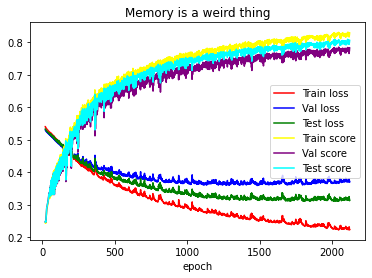

In [ ]:
#if losses and scores are already in memory
plot_losses_n_scores(train_every_epoch_loss, val_every_epoch_loss, test_every_epoch_loss, 'Memory is a weird thing', 20,
         train_every_epoch_score, val_every_epoch_score, test_every_epoch_score)

In [ ]:
get_n_plot_losses(basepath, 'gcn_adj_', load_identifier, begin_plot_index=100)

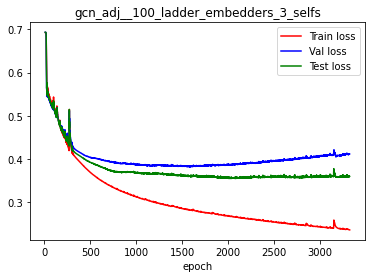

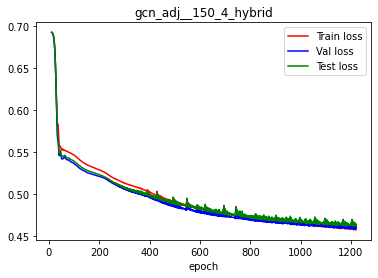

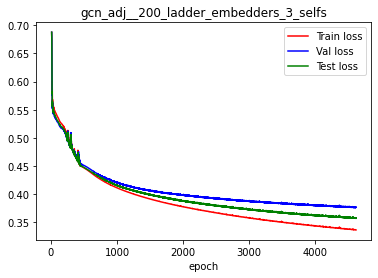

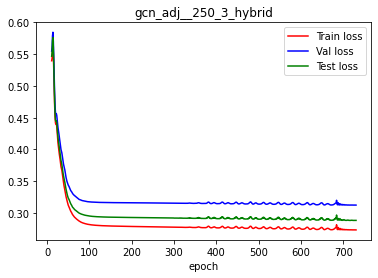

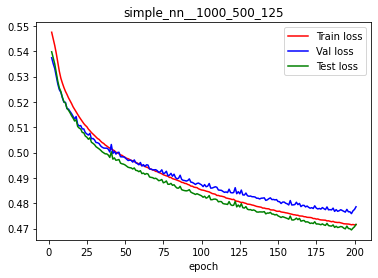

In [ ]:
load_ids=['_100_ladder_embedders_3_selfs', '_150_4_hybrid', '_200_ladder_embedders_3_selfs', '_250_3_hybrid']
for load_id in load_ids:
  get_n_plot_losses(basepath, 'gcn_adj_', load_id, 10)
load_ids=['_1000_500_125']
for load_id in load_ids:
  get_n_plot_losses(basepath, 'simple_nn_', load_id, 1)

## Dummy example to test on

In [ ]:
#dummy example
dum_feats=torch.FloatTensor([[1, 1, 0, 1], [1, 0, 1, 0], [0, 0, 0, 1], [1, 1, 1, 1], [0, 0, 1, 0], [1, 0, 1, 0]])
dum_classes=torch.FloatTensor([[1, 0], [1, 1], [1, 0], [0,0], [1, 1], [0, 1]])
dum_adj_matrix=torch.FloatTensor([[1, 0, 1, 1, 0, 0], [0, 1, 0, 0, 0, 1],
                                  [1, 1, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1],
                                  [0, 0, 0, 1, 1, 0], [0, 0, 1, 0, 1, 1]
                                  ])
dum_sums_adj_matrix=torch.sum(dum_adj_matrix, dim=0)
dum_sums_adj_matrix[dum_sums_adj_matrix==0.]=1
dum_norm_matrix=torch.diag(dum_sums_adj_matrix**-1)
print(dum_norm_matrix)

NameError: ignored

In [ ]:
dum_model=GCN(3, dum_feats.shape[-1], 100, dum_classes.shape[-1])
dum_optim=torch.optim.Adam(dum_model.parameters(), lr=10e-4)

In [ ]:
for e in range(1000):
  loss_func=torch.nn.BCEWithLogitsLoss()
  dum_optim.zero_grad()
  dum_embeddings=dum_model(dum_feats, dum_adj_matrix, dum_norm_matrix)
  dum_preds=dum_model.classify(dum_embeddings)
  dum_loss=loss_func(dum_preds, dum_classes)
  dum_loss.backward()
  with torch.no_grad():
    dum_optim.step()
    print(f'epoch {e}')
    print()
    # print(dum_embeddings)
    print(dum_preds)
    print(dum_classes)
    print(dum_loss.item())
    print('\n\n')

# 4. Graph Attention Network (GAT)

## Model definition

### Old forward method

In [ ]:
# # newest old forward
#   def forward(self, node_features: torch.Tensor, index_mapping: dict, adj_dict: dict, focus_ids: list):
#     """
#     -node_features is a tensor of features of nodes required for all iterrations in batch
#     -index_mapping maps actual node_ids to indexes of node_features rows (which are the ones which appear in adj dict)
#     -adj_dict is an adjacency dictionary of all the nodes (no point in constructing one just with the nodes needed for iteration)
#     -focus_ids is a list of lists of all the ids that are important at a given level (from left to right: farthest to nearest)
#     focus_ids[0] will be the ids of nodes that are at level 1, i.e. immediately above leaves etc.
#      The index mapping will need to be updated at each iteration so that we have a clue what's going on
#     """

#     #START THE ITERATIONS
#     current_feats=node_features
#     for i in range(len(self.linears_for_neighbors)) :
#       #an iteration starts
#       print(f'iteration {i}')
#       linear_neighbors = self.linears_for_neighbors[i]
#       attention=self.attentions[i]
      
#       next_feats=torch.FloatTensor(len(focus_ids[i]), linear_neighbors.out_features)
#       new_index_mapping={}
#       current_row=0
#       for node in focus_ids[i]:
#         node_neighbors_feats=current_feats[[index_mapping[neighbor] for neighbor in adj_dict[node]]] #will have shape no_neighbors x no_feats_per_node
#         node_feats=current_feats[[index_mapping[node]]]
#         # print(f'node {node} neighbor feats shape {node_neighbors_feats.shape} and self feats shape {node_feats.shape}')
#         node_attention_feeder=torch.cat( (linear_neighbors(node_neighbors_feats.view(node_neighbors_feats.shape[0], -1)),
#                                           linear_neighbors(node_feats.view(1,-1).repeat(node_neighbors_feats.shape[0], 1)) ), dim=1)
#         #get attention coefficients and normalise them
#         node_attention_coefficients=F.leaky_relu(attention(node_attention_feeder), negative_slope=0.2)
#         node_attention_coefficients=F.softmax(node_attention_coefficients, dim=0)
#         # print(f'after node {node} current attention feeder has shape {current_attention_feeder.shape}')
        
#         #get linouts
#         node_neighbor_linout_feats=linear_neighbors(node_neighbors_feats)
#         #compute next feats
#         next_feats[current_row]=torch.mm(node_attention_coefficients.view(1, len(list(adj_dict[node]))),
#                                     node_neighbor_linout_feats.view(len(list(adj_dict[node])),-1))
#         #sorting the index messiness
#         new_index_mapping[node]=current_row
#         current_row += 1
#       current_feats=next_feats
#       index_mapping=new_index_mapping
#       print(f'final feats out of layer {i} have shape {current_feats.shape}')
#       current_feats=F.relu(current_feats)
#     return current_feats, index_mapping

In [ ]:
# #backup "global" epoch forward
# #START THE ITERATIONS
#     current_feats=node_features
#     for i in range(len(self.linears_for_neighbors)) :
#       #an iteration starts
#       linear_neighbors = self.linears_for_neighbors[i]
#       attention=self.attentions[i]
      
#       next_feats=torch.FloatTensor(current_feats.shape[0], linear_neighbors.out_features)
#       for node in range(len(adj_dict.keys())):
#         node_neighbors_feats=current_feats[list(adj_dict[node])] #will have shape no_neighbors x no_feats_per_node
#         node_feats=current_feats[int(node)]
#         node_attention_feeder=torch.cat( (linear_neighbors(node_neighbors_feats.view(node_neighbors_feats.shape[0], -1)),
#                                           linear_neighbors(node_feats.view(1,node_feats.shape[0]).repeat(node_neighbors_feats.shape[0], 1)) ), dim=1)
#         #variant WITHOUT W
#         # node_attention_feeder=torch.cat( (node_neighbors_feats.view(node_neighbors_feats.shape[0], -1),
#         #                                       node_feats.view(1,node_feats.shape[0]).repeat(node_neighbors_feats.shape[0], 1) ), dim=1)
#         #node attention feeder will have shape no_neighbors_of_node x no_node_features*2

#         #get attention coefficients and normalise them
#         node_attention_coefficients=F.leaky_relu(attention(node_attention_feeder), negative_slope=0.2)
#         node_attention_coefficients=F.softmax(node_attention_coefficients, dim=0)
#         # print(f'after node {node} current attention feeder has shape {current_attention_feeder.shape}')
        
#         #get linouts
#         node_neighbor_linout_feats=linear_neighbors(current_feats[list(adj_dict[node])])
#         #compute next feats
#         next_feats[node]=torch.mm(node_attention_coefficients.view(1, len(list(adj_dict[node]))),
#                                     node_neighbor_linout_feats.view(len(list(adj_dict[node])),-1))
        
#       current_feats=next_feats
#       print(f'final feats out of layer {i} have shape {current_feats.shape}')
#       current_feats=F.relu(current_feats)
#     return current_feats

In [ ]:
# def forward_old(self, node_features: torch.Tensor, adj_dict: dict):
#     #GETTING NODE NEIGHBORS INDECES ONCE AND FOR ALL
#     node_neighbors_indeces=[] #a list indicating up to where in the output attention feeder matrix one should look to find the features of the node neighbors
#     for node in range(len(adj_dict.keys())):
#       if node_neighbors_indeces:
#         node_neighbors_indeces.append(node_neighbors_indeces[-1]+len(adj_dict[node]))
#       else:
#         node_neighbors_indeces.append(len(adj_dict[node]))
  
#     #START THE ITERATIONS
#     current_feats=node_features
#     for i in range(len(self.linears_for_neighbors)) :
#       #an iteration starts
#       linear_neighbors = self.linears_for_neighbors[i]
#       attention=self.attentions[i]



#       #constructing the attention coefficients
#       node_neighbors_feats=current_feats[list(adj_dict[0])] #will have shape no_neighbors x no_feats_per_node
#       node_feats=current_feats[int(0)]
#       # current_attention_feeder=torch.cat( (linear_neighbors(node_neighbors_feats.view(node_neighbors_feats.shape[0], -1)),
#       #                                           linear_neighbors(node_feats.view(1,node_feats.shape[0]).repeat(node_neighbors_feats.shape[0], 1))), dim=1)
#       #variant WITHOUT W:
#       current_attention_feeder=torch.cat( (node_neighbors_feats.view(node_neighbors_feats.shape[0], -1),
#                                                 node_feats.view(1,node_feats.shape[0]).repeat(node_neighbors_feats.shape[0], 1) ), dim=1)
#       for node in range(1,len(adj_dict.keys())):
#         node_neighbors_feats=current_feats[list(adj_dict[node])] #will have shape no_neighbors x no_feats_per_node
#         node_feats=current_feats[int(node)]
#         # current_attention_feeder=torch.cat( (current_attention_feeder,
#         #                                       torch.cat( (linear_neighbors(node_neighbors_feats.view(node_neighbors_feats.shape[0], -1)),
#         #                                       linear_neighbors(node_feats.view(1,node_feats.shape[0]).repeat(node_neighbors_feats.shape[0], 1)) ), dim=1) )
#         # , dim=0)
#         #variant WITHOUT W
#         current_attention_feeder=torch.cat( (current_attention_feeder,
#                                               torch.cat( (node_neighbors_feats.view(node_neighbors_feats.shape[0], -1),
#                                               node_feats.view(1,node_feats.shape[0]).repeat(node_neighbors_feats.shape[0], 1) ), dim=1) )
#         , dim=0)
#         # print(f'after node {node} current attention feeder has shape {current_attention_feeder.shape}')
#       #current attention feeder will have shape no_links_in_graph x no_node_features*2
#       attention_coefficients=F.leaky_relu(attention(current_attention_feeder), negative_slope=0.2) #negative slope of 0.2 was used in the article
#       #attention_coefficients will have shape no_links_in_graph x 1 (1 coef for each link)


#       #CONSTRUCTING NEXT FEATURES
#       next_feats=torch.FloatTensor(current_feats.shape[0], linear_neighbors.out_features)
#       #using attention coefficients to compute next level features
#         #WE NEED TO RECOMPUTE THE RESULTS OF PASSING THROUGH THE LINEARS BECAUSE THEY WERE ALREADY USED IN PASSING THROUGH ATTENTION
#       node_neighbor_linout_feats=linear_neighbors(current_feats[list(adj_dict[0])])
#       #normalising first node attentions
#       attention_coefficients[:node_neighbors_indeces[0]]=F.softmax(attention_coefficients[:node_neighbors_indeces[0]], dim=0)
#       next_feats[0]=torch.mm(attention_coefficients[:node_neighbors_indeces[0]].view(1, node_neighbors_indeces[0]),
#                             node_neighbor_linout_feats.view(node_neighbors_indeces[0], -1))
#       for node in range(1,len(adj_dict.keys())):
#         #I want dot product between attentions of current node and the outputs of current node neighbors through through linear
#         #To use mathmul, attentions need to be shape 1 x no_neighbors_current_node
#         #                outputs through linears need to be shape no_neighbors_current_node x output_features_of_linear_layer

#         #normalising:
#         attention_coefficients[node_neighbors_indeces[node-1]:node_neighbors_indeces[node]]=F.softmax(attention_coefficients[node_neighbors_indeces[node-1]:node_neighbors_indeces[node]], dim=0)

#         #getting output feats again:
#         node_neighbor_linout_feats=linear_neighbors(current_feats[list(adj_dict[node])])

#         #computation:
#         next_feats[node]=torch.mm(attention_coefficients[node_neighbors_indeces[node-1]:node_neighbors_indeces[node]].view(1, node_neighbors_indeces[node]-node_neighbors_indeces[node-1]),
#                                     node_neighbor_linout_feats.view(node_neighbors_indeces[node]-node_neighbors_indeces[node-1],-1))
#       current_feats=next_feats
#       return attention_coefficients
#       print(f'final feats out of layer {i} have shape {current_feats.shape}')
#       current_feats=F.relu(current_feats)
#     return current_feats

Batches will consist of the features of all the nodes needed **for all iterations**, but features will be augmented with a dimension that tells the actual node they correspond to (when making a batch-feature tensor, the node certain features pertain to will no longer be the row number of those features). The model receives an adjacency dict **only of the nodes needed for all iterations** and the features corresponding to that iteration. The batch adjacency dict will be constructed in the train_epoch function, while the batch features will be constructed in a separate function which will (hopefully) act as a loader. I'll also have a torch loader just for ids so I can get batches in a random way.

### Class def

In [ ]:
class GAT(nn.Module):
  def __init__(self, no_iters, in_features_size, embedding_size, no_classes):
    """
    2 attentions for each iteration, one for neighbors, the other for nodes; then summed in forward
    """
    super().__init__()
    self.no_iters=no_iters
    self.emb_size=embedding_size
    self.feature_size=in_features_size
    linears_for_neighbors=[]
    linears_for_self=[]
    attentions1=[]
    attentions2=[]
    cur_size=in_features_size*2
    for i in range(no_iters-1):
        if i==0:
          linears_for_neighbors.append(nn.Linear(in_features_size, cur_size, bias=False))
          # linears_for_self.append(nn.Linear(in_features_size, cur_size, bias=False))
          attentions1.append(nn.Linear(cur_size, 1, bias=False))
          attentions2.append(nn.Linear(cur_size, 1, bias=False))
          # attentions.append(nn.Linear(in_features_size*2, 1)) #variant WITHOUT W
        else:
          linears_for_neighbors.append(nn.Linear(cur_size, cur_size, bias=False))
          # linears_for_self.append(nn.Linear(cur_size, cur_size, bias=False))
          #attentions has to have 2*OUTPUT size of linears_for_neighbors
          attentions1.append(nn.Linear(cur_size, 1, bias=False))
          attentions2.append(nn.Linear(cur_size, 1, bias=False))
        # cur_size=cur_size*2
    # linears_for_neighbors.append(GCNFeatureEmbedder(cur_size, embedding_size, bias=False))
    linears_for_neighbors.append(nn.Linear(cur_size, embedding_size, bias=False))
    # linears_for_self.append(nn.Linear(cur_size, embedding_size, bias=False))
    attentions1.append(nn.Linear(embedding_size, 1, bias=False))
    attentions2.append(nn.Linear(embedding_size, 1, bias=False))
    # attentions.append(nn.Linear(cur_size*2,1)) #variant WITHOUT W
    self.linears_for_neighbors=nn.ModuleList(linears_for_neighbors)
    self.attentions1=nn.ModuleList(attentions1)
    self.attentions2=nn.ModuleList(attentions2)
    self.classifier=nn.Linear(embedding_size, no_classes, bias=False)
  
  def forward(self, feats: torch.Tensor, adj_matrix: torch.Tensor):
    """
    -feats are all the features of all nodes in a connected component
    -adj_matrix is the adjacency matrix of that component (has dimension no_nodes_in_component^2)
    """
    #START THE ITERATIONS
    current_feats=feats
    for i in range(len(self.linears_for_neighbors)) :
      #an iteration starts
      proj_neighbors=self.attentions1[i](self.linears_for_neighbors[i](current_feats))
      proj_nodes=self.attentions2[i](self.linears_for_neighbors[i](current_feats))
      #proj_neighbors and _nodes will both be of size no_nodes_in_batch x 1
      attention_coefs=torch.add(proj_neighbors.view(1, -1), proj_nodes.view(-1, 1))

      #now element attention_coefs[i, j] is attention of node j seen as (potential) neighbor of node i
      #lin i of attention_coefs will be coefs associate with node i (coefs of neighbors)

      #masking again: (element wise matrix multiplication with adjacency matrix, which is masked with -inf where there are no links for softmax - OUTSIDE FWD)
      
      # attention_coefs=torch.mul(adj_matrix, attention_coefs)
      # nans=torch.isnan(attention_coefs)
      # infs=torch.isinf(attention_coefs)
      # if torch.any(nans):
      #   attention_coefs[nans]=float('-inf') #the 0's in the attention_coefs matrix that were multiplied by -inf
      # if torch.any(infs):
      #   attention_coefs[infs]=float('-inf') #the negative numbers in the coefs matrix that were multiplied by -inf => +inf
      
      attention_coefs[adj_matrix==0]=float('-inf')
      
      #passing through leakyReLU
      leaky=torch.nn.LeakyReLU(0.2)
      attention_coefs=leaky(attention_coefs)


      attention_coefs=torch.softmax(attention_coefs, dim=1) #dim=1 i.e. softmax along each ROW

      current_feats=torch.mm(attention_coefs, self.linears_for_neighbors[i](current_feats))
      # if (current_feats.shape[0]==1): print(f'iteration {i} feats: {current_feats}')
    return current_feats
  def classify(self, embedded):
    #no activation here because it already went through activation at previous level and it will go through sigmo once outputed
    out=self.classifier(embedded)
    return out

## Dummy example to test on

In [ ]:
#dummy example
dum_feats=torch.FloatTensor([[1, 1, 0, 1], [1, 0, 1, 0], [0, 0, 0, 1], [1, 1, 1, 1], [0, 0, 1, 0], [1, 0, 1, 0]])
dum_classes=torch.FloatTensor([[1, 0], [1, 1], [1, 0], [0,0], [1, 1], [0, 1]])
dum_adj_matrix=torch.FloatTensor([[1, 0, 1, 1, 0, 0], [0, 1, 0, 0, 0, 1],
                                  [1, 1, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1],
                                  [0, 0, 0, 1, 1, 0], [0, 0, 1, 0, 1, 1]
                                  ])
dum_adj_dict={0: [0, 2, 3], 1: [1, 5], 2:[0, 1, 2], 3:[1, 3, 5], 4:[3,4], 5:[2,4,5]}
print(dum_adj_dict)

{0: [0, 2, 3], 1: [1, 5], 2: [0, 1, 2], 3: [1, 3, 5], 4: [3, 4], 5: [2, 4, 5]}


In [ ]:
dum_model=GAT(2, dum_feats.shape[-1], 100, dum_classes.shape[-1])
dum_optim=torch.optim.Adam(dum_model.parameters(), lr=10e-4)

In [ ]:
a=dum_model(dum_feats,dum_adj_matrix)
print(a)

tensor([[-2.7541e-01, -1.7528e-01,  1.8937e-01, -9.9994e-02, -1.1203e-01,
          2.9951e-01,  1.8713e-01,  9.7698e-02, -3.4089e-01, -1.7595e-01,
          1.7594e-01,  2.6833e-02,  4.1425e-01,  1.0789e-01,  6.4229e-02,
          1.4282e-01,  1.5338e-01,  1.2812e-01, -4.1082e-03, -3.8894e-01,
          8.0998e-02,  7.9351e-02, -2.9964e-02, -1.8237e-02,  1.4513e-01,
          1.9768e-01, -1.3424e-01,  2.3669e-02, -5.9221e-02, -2.6011e-01,
         -5.4506e-02,  3.6337e-01,  1.6284e-01, -4.9513e-02, -1.0842e-02,
          7.1001e-02, -2.4584e-01, -1.7172e-01,  8.8334e-02,  1.0920e-01,
         -1.4831e-01,  9.8020e-02,  4.5889e-02, -1.7385e-01, -1.0253e-01,
          1.3532e-01,  2.5559e-01, -1.1007e-01,  6.9102e-02,  2.0425e-01,
         -1.6637e-01, -2.4140e-02, -1.0402e-02,  1.8391e-01,  1.5243e-01,
         -1.5669e-02,  9.3306e-02,  4.1040e-01, -1.0565e-01, -3.0465e-01,
          1.4968e-01, -1.7320e-01, -6.6113e-02, -3.5108e-01, -2.9275e-01,
          1.3278e-01,  3.3695e-02, -1.

In [ ]:
for e in range(1):
  loss_func=torch.nn.BCEWithLogitsLoss()
  dum_optim.zero_grad()
  dum_embeddings=dum_model(dum_feats, dum_adj_dict)
  # dum_loss=torch.sum(dum_embeddings)
  dum_preds=dum_model.classify(dum_embeddings)
  dum_loss=loss_func(dum_preds, dum_classes)
  print(torchviz.make_dot(dum_loss))
  dum_loss.backward()
  with torch.no_grad():
    dum_optim.step()
    print(f'epoch {e}')
    print()
    # print(dum_embeddings)
    print(dum_preds)
    print(dum_classes)
    print(dum_loss.item())
    print('\n\n')

##Train model

### Old functions backup

In [ ]:
# def train_epoch_gat(model:GAT, optim, adj_dict, feats, train_loader, class_map, device):
#   model=model.to(device)
  
#   loss_func=torch.nn.BCEWithLogitsLoss()
#   optim.zero_grad()

#   epoch_loss=0.
#   epoch_score=0.
#   for component_id in range(len(adj_matrices_comps)):
#     batch_node_ids=[elem.item() for elem in batch_node_ids]
#     batch_focus_ids, batch_features, index_mapping = get_batch_forward_information(model.no_iters, batch_node_ids, adj_dict, feats)
    
#     #model takes as forward args: node_features: torch.Tensor, index_mapping: dict, adj_dict: dict, focus_ids: list
#     batch_preds, returned_index_mapping=model(batch_features, index_mapping, adj_dict, batch_focus_ids)
#     batch_preds=model.classify(batch_preds)
#     print('classified')

#     #we need to recover the batch preds ordering. we know that the batch classes are ordered according to the batch_node_ids
#     #we need to order the batch_preds accordingly as well
#     ordered_batch_preds=torch.Tensor(batch_preds.shape)
#     for row_index in range(len(batch_node_ids)):
#       ordered_batch_preds[row_index]=batch_preds[returned_index_mapping[batch_node_ids[row_index]]]

#     loss=loss_func(ordered_batch_preds, batch_classes)
#     print(f'loss computed at batch {batch_no} is {loss.item()}')
#     loss.backward()
#     print('backward complete')
#     with torch.no_grad():
#       optim.step()
#       epoch_loss+=loss.item()
#       no_batches+=1
#       score=get_accuracy(torch.sigmoid(ordered_batch_preds), batch_classes)
#       epoch_score+=score
#   return epoch_loss/no_batches, epoch_score/no_batches

In [ ]:
# def get_batch_forward_information(no_iters, batch_node_ids, adj_dict, feats):
#   """
#   function that returns:
#   -features of leaves nodes for all trees of nodes in batch_node_ids
#   -a list of lists of node ids corresponding to each level of the reunion of the trees of nodes in batch_node_ids
#   -index_mapping: a map of the actual node ids in batch_node_ids to rows of features

#   feats is the entire features matrix
#   """
#   #we want to get the focus nodes for the no_iters of the model
#   #farthest first, nearest last; last focus nodes will be nodes in batch, first ones will be the ones just before leaves
#   batch_focus_ids=[batch_node_ids]
#   for i in range(1,no_iters):
#     iteration_nodes=set([])
#     for node_id in batch_focus_ids[0]:
#       iteration_nodes=iteration_nodes | set(adj_dict[node_id])
#     batch_focus_ids.insert(0, list(iteration_nodes))
#     assert (len(set(batch_focus_ids[0]) & set(batch_focus_ids[1])) == len(set(batch_focus_ids[1])) ), "Not all nodes were kept for next iteration"
#   for i in range(len(batch_focus_ids)):
#     print(f'there are {len(batch_focus_ids[i])} nodes for iteration {i}')
#   print('\n\n')
#   #now on position 0 of batch_focus_ids we have the direct fathers of nodes that have just leaves; we also want the batch features
#   #the batch features will just be the features of the leaves, because the adj_dict was constructed such that every node has itself as its' neighbor

#   leaf_nodes=set([])
#   for node_id in batch_focus_ids[0]:
#     leaf_nodes=leaf_nodes | set(adj_dict[node_id])

#   batch_features=torch.Tensor(len(leaf_nodes), model.feature_size)
#   index_mapping={}
#   current_row=0
#   for node in list(leaf_nodes):
#     batch_features[current_row]=feats[node]
#     index_mapping[node]=current_row
#     current_row+=1
#   return batch_focus_ids, batch_features, index_mapping

### Train loader - NO LONGER NEEDED

In [ ]:
def make_batch_loader_gat(ids_selector: list, id_map: dict, features: np.array, class_map: dict, batch_size: int, shuffle, device):
  """
  id_map: only used for obtaining the right line in features
  ids_selector: list of ids that are in the wanted dataset
  """
  out_classes=torch.FloatTensor([class_map[str(idx)] for idx in ids_selector])
  out_classes=out_classes.to(device)
  from torch.utils.data import TensorDataset
  from torch.utils.data import DataLoader
  dataset = TensorDataset(torch.tensor(ids_selector), out_classes)
  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)
  return data_loader

In [ ]:
train_loader=make_batch_loader_gat(ids_selector=train_ids, id_map=id_map, features=feats, class_map=class_map, batch_size=300, shuffle=True, device=device)
# val_loader=make_batch_loader_gat(ids_selector=val_ids, id_map=id_map, features=feats, class_map=class_map, batch_size=len(val_ids), shuffle=False, device=device)
# test_loader=make_batch_loader_gat(ids_selector=test_ids, id_map=id_map, features=feats, class_map=class_map, batch_size=len(test_ids), shuffle=False, device=device)

### Score function

In [ ]:
def get_accuracy(predictions, labels, probability=0.5):
  """
  predictions are of the shape no_nodes x no_classes, representing probability of each node being in each class
  labels are the same shape only binary

  average='weighted' is used in f1_score because it accounts for possible class imbalances
  """
  assert predictions.shape == labels.shape, "Predictions and labels don't have same shape: "+{predictions.shape}+" vs. "+{labels.shape}+" respectively."
  from sklearn.metrics import f1_score
  cutoff=(predictions>probability).type(torch.FloatTensor)
  score=f1_score(y_true=labels, y_pred=cutoff, average='weighted')
  return(score)

### Train functions

In [ ]:
def train_epoch_gat(model:GAT, optim, connected_comps, feats_comps, adj_matrices_comps, 
                    components_train_indexes, components_classes_train, no_train_comps, device):
  model=model.to(device)
  loss_func=torch.nn.BCEWithLogitsLoss()
  optim.zero_grad()

  epoch_train_loss=0.

  for component_id in range(len(connected_comps)):
    if components_train_indexes[component_id]:
      comp_preds=model(feats_comps[component_id], adj_matrices_comps[component_id])
      comp_preds=model.classify(comp_preds)

      comp_preds_train=comp_preds[components_train_indexes[component_id]]
      print(comp_preds_train)
      comp_classes_train=components_classes_train[component_id]
      print(comp_classes_train)
      
      train_loss=loss_func(comp_preds_train, comp_classes_train.type(torch.FloatTensor))

      train_loss.backward()

      with torch.no_grad():
        optim.step()
        epoch_train_loss+=train_loss.item()

    
  return epoch_train_loss/no_train_comps

In [ ]:
def train_gat_model(model, optim, components_separated_data, no_epochs, save_identifier, model_type, save_every):
  components_train_indexes=components_separated_data.components_train_indexes
  components_val_indexes=components_separated_data.components_val_indexes
  components_test_indexes=components_separated_data.components_test_indexes
  components_classes_train=components_separated_data.components_classes_train
  components_classes_val=components_separated_data.components_classes_val
  components_classes_test=components_separated_data.components_classes_test
  no_train_comps=components_separated_data.no_train_comps
  no_val_comps=components_separated_data.no_val_comps
  no_test_comps=components_separated_data.no_test_comps
  for e in range(no_epochs):
    epoch_train_loss = train_epoch_gat(model, optim, connected_comps, feats_comps, adj_matrices_comps,
                                       components_train_indexes, components_classes_train, no_train_comps, device)
    with torch.no_grad():
      if e%save_every==0:
        torch.save(model.state_dict(), basepath+model_type+save_identifier)
     
      #adding to total vectors for plot
      epoch_train_score=0.
      epoch_val_loss=0.
      epoch_val_score=0.
      epoch_test_loss=0.
      epoch_test_score=0.
      for component_id in range(len(connected_comps)):
        comp_preds=model(feats_comps[component_id], adj_matrices_comps[component_id])
        comp_preds=model.classify(comp_preds)
        loss_func=torch.nn.BCEWithLogitsLoss()

        if components_train_indexes[component_id]:
            comp_preds_train=comp_preds[components_train_indexes[component_id]]
            comp_classes_train=components_classes_train[component_id]
            train_score=get_accuracy(torch.sigmoid(comp_preds_train), comp_classes_train)
            epoch_train_score+=train_score

        
        if components_val_indexes[component_id]:
            comp_preds_val=comp_preds[components_val_indexes[component_id]]
            comp_classes_val=components_classes_val[component_id]
            val_loss=loss_func(comp_preds_val, comp_classes_val.type(torch.FloatTensor))
            epoch_val_loss+=val_loss.item()
            val_score=get_accuracy(torch.sigmoid(comp_preds_val), comp_classes_val)
            epoch_val_score+=val_score

        if components_test_indexes[component_id]:
            comp_preds_test=comp_preds[components_test_indexes[component_id]]
            comp_classes_test=components_classes_test[component_id]
            test_loss=loss_func(comp_preds_test, comp_classes_test.type(torch.FloatTensor))
            epoch_test_loss+=test_loss.item()
            test_score=get_accuracy(torch.sigmoid(comp_preds_test), comp_classes_test)
            epoch_test_score+=test_score

      epoch_train_score/=no_train_comps
      epoch_val_loss/=no_val_comps
      epoch_val_score/=no_val_comps
      epoch_test_loss/=no_test_comps
      epoch_test_score/=no_test_comps
      print(f'epoch {e} train loss {epoch_train_loss} and score {epoch_train_score}')
      train_every_epoch_loss.append(epoch_train_loss)
      val_every_epoch_loss.append(epoch_val_loss)
      test_every_epoch_loss.append(epoch_test_loss)
      train_every_epoch_score.append(epoch_train_score)
      val_every_epoch_score.append(epoch_val_score)
      test_every_epoch_score.append(epoch_test_score)
      if e%save_every==0:
        import pickle
        with open(basepath+model_type+'_train_losses_'+save_identifier, 'wb') as filehandle:
          pickle.dump(train_every_epoch_loss, filehandle)
        with open(basepath+model_type+'_val_losses_'+save_identifier, 'wb') as filehandle:
          pickle.dump(val_every_epoch_loss, filehandle)
        with open(basepath+model_type+'_test_losses_'+save_identifier, 'wb') as filehandle:
          pickle.dump(test_every_epoch_loss, filehandle)
        with open(basepath+model_type+'_train_scores_'+save_identifier, 'wb') as filehandle:
          pickle.dump(train_every_epoch_score, filehandle)
        with open(basepath+model_type+'_val_scores_'+save_identifier, 'wb') as filehandle:
          pickle.dump(val_every_epoch_score, filehandle)
        with open(basepath+model_type+'_test_scores_'+save_identifier, 'wb') as filehandle:
          pickle.dump(test_every_epoch_score, filehandle)
        

### Actual train

In [ ]:
model=GAT(3, feats.shape[-1], 200, no_classes)

In [ ]:
optim=torch.optim.Adam(model.parameters(), lr=10e-5)

In [ ]:
no_epochs=1000

In [ ]:
save_identifier=str(model.emb_size)+'_3layer_'+'nobias'+'_intermtwiceinput'
model_type='gat'

In [ ]:
train_every_epoch_loss=[]
val_every_epoch_loss=[]
test_every_epoch_loss=[]
train_every_epoch_score=[]
val_every_epoch_score=[]
test_every_epoch_score=[]

In [ ]:
train_gat_model(model, optim, components_separated_data, no_epochs, save_identifier, model_type='gat', save_every=5)

tensor([[ 0.5639, -2.3492, -1.8110,  ...,  0.5768, -0.5911, -0.7358],
        [ 2.1919, -3.4974, -1.6638,  ...,  0.9782,  0.3628,  0.4297],
        [ 0.6598, -2.3391, -1.8096,  ...,  1.2518,  0.0104, -0.8989],
        ...,
        [ 1.2646, -2.6328, -1.6368,  ...,  0.8077, -0.0763, -0.3062],
        [ 0.5512, -1.2878, -0.8552,  ...,  0.9582,  0.0825, -0.7848],
        [ 0.7692, -2.0607, -1.4437,  ...,  0.8001, -0.1667, -0.6354]],
       grad_fn=<IndexBackward>)
tensor([[1, 0, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 1],
        [1, 1, 0,  ..., 1, 1, 0]])
tensor([[ 2.0826, -5.6561,  4.0923,  4.4711,  2.9976, -4.9068,  4.4282, -0.5732,
         -1.0498,  3.6734, -0.7949, -4.4993,  1.6672, -3.8576, -1.4027, -4.6661,
         -6.2535,  1.8180, -5.4650,  3.5317,  2.3831,  2.1706,  2.3581,  2.6816,
         -5.9797,  2.2589,  2.3007, -6.0691,  2.3760, -3.6120,  1.6643,  

KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load(basepath+'gat'+save_identifier))

<All keys matched successfully>

Plot

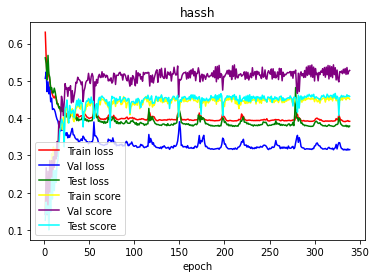

In [ ]:
plot_losses_n_scores(train_every_epoch_loss, val_every_epoch_loss, test_every_epoch_loss, 'hassh', 0,
         train_every_epoch_score, val_every_epoch_score, test_every_epoch_score)

Load back

In [ ]:
!ls "$basepath"

adj_matrices_comps
gat100_2layer__intermtwiceinput
gat100_3layer__intermtwiceinput
gat100_intermtwiceinput
gat130_2layer_nobias_intermtwiceinput
gat150_2layer__intermtwiceinput
gat150_2layer_nobias_intermtwiceinput
gat150_3layer__intermtwiceinput
gat150_3layer_nobias_intermtwiceinput
gat200_2layer__intermtwiceinput
gat200_3layer_nobias_intermtwiceinput
gat300_2layer_nobias_intermtwiceinput
gat50_2layer_nobias_intermtwiceinput
gat_adjacency_emb100_intermtwiceinput
gat_adj_test_losses_100_intermtwiceinput
gat_adj_test_scores_100_intermtwiceinput
gat_adj_train_scores_100_intermtwiceinput
gat_adj_val_losses_100_intermtwiceinput
gat_adj_val_scores_100_intermtwiceinput
gat_emb100_intermtwiceinput
gat_test_losses_100_2layer__intermtwiceinput
gat_test_losses_100_3layer__intermtwiceinput
gat_test_losses_100_intermtwiceinput
gat_test_losses_130_2layer_nobias_intermtwiceinput
gat_test_losses_150_2layer__intermtwiceinput
gat_test_losses_150_2layer_nobias_intermtwiceinput
gat_test_losses_150_3layer

In [ ]:
save_identifier="150_2layer_nobias_intermtwiceinput"

In [ ]:
import pickle
with open(basepath+model_type+'_train_losses_'+save_identifier, 'rb') as filehandle:
  train_every_epoch_loss=pickle.load(filehandle)
with open(basepath+model_type+'_val_losses_'+save_identifier, 'rb') as filehandle:
  val_every_epoch_loss=pickle.load(filehandle)
with open(basepath+model_type+'_test_losses_'+save_identifier, 'rb') as filehandle:
  test_every_epoch_loss=pickle.load(filehandle)
with open(basepath+model_type+'_train_scores_'+save_identifier, 'rb') as filehandle:
  train_every_epoch_score=pickle.load(filehandle)
with open(basepath+model_type+'_val_scores_'+save_identifier, 'rb') as filehandle:
  val_every_epoch_score=pickle.load(filehandle)
with open(basepath+model_type+'_test_scores_'+save_identifier, 'rb') as filehandle:
  test_every_epoch_score=pickle.load(filehandle)

In [ ]:
print(train_every_epoch_loss)
print(train_every_epoch_score)
print(val_every_epoch_loss)
print(val_every_epoch_score)
print(test_every_epoch_loss)
print(test_every_epoch_score)

[0.6302408564280957, 0.5604927429810483, 0.5022652553434067, 0.5304338041930756, 0.5137604290183554, 0.4996703771834678, 0.4799759896987296, 0.4693790400044081, 0.4625750436209776, 0.45587134862794204, 0.45403222088563316, 0.4596546465174315, 0.45386199680295713, 0.4418364635094049, 0.43681542939962226, 0.4296186492758545, 0.42745078485260934, 0.42119202047408105, 0.4240594532935226, 0.42195069004999514, 0.4279337097454737, 0.4189191885758191, 0.41732089944441425, 0.409507437251964, 0.4118652804705136, 0.4070526226772927, 0.4162068004077152, 0.40926358288926806, 0.4166760139613155, 0.41404718267235985, 0.42032709796529044, 0.40977707231773974, 0.41410949401646613, 0.40775369850254833, 0.4109787658759779, 0.40631388315108624, 0.4104386120776403, 0.40297915785291055, 0.40403083620643726, 0.4050073520829059, 0.4065720913884666, 0.40529024192420615, 0.4076900950884397, 0.4139543794073224, 0.41047210843733295, 0.40769094175961307, 0.4032422893252434, 0.4023346285275035, 0.3999504562290237, 